In [1]:
import os
import random
import pandas as pd
import numpy as np
from box import Box

from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from typing import Tuple
from matplotlib import pyplot as plt

In [2]:
def setSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

In [3]:
dir_base = os.path.join(os.path.join('/opt','ml','paper','RecSys'))
dir_data = os.path.join(dir_base, 'Data', 'ml-latest-small')
path_rating = os.path.join(dir_data, 'ratings.csv')
dir_file_path = {
    'dir_base': dir_base,
    'dir_data': dir_data,
    'path_rating': path_rating,
}

dir_file_path = Box(dir_file_path)

In [4]:
class DataInfo():
    def __init__(self, file_path: str) -> None:
        self.df = pd.read_csv(file_path)
        self.user_encoder, self.movie_encoder = self._encode()

        self.set_users = set(self.df['userId'].unique())
        self.num_users = len(self.set_users)
        self.min_feedback = 5 # for resolving cold-start problem
        self.set_movies = set(self.df['movieId'].unique())
        self.num_movies = len(self.set_movies)
        self.set_train_movies = self._moreThanFeedback()
        self.num_train_movies = len(self.set_train_movies)

        self.user_negative_samples = self._makeNeg()      


    def _moreThanFeedback(self):
        movie_ids_for_training = list()
        for movie_id in self.df['movieId'].unique():
            if self.df[self.df['movieId'] == movie_id].shape[0] >= self.min_feedback:
                movie_ids_for_training.append(movie_id)
        
        return set(movie_ids_for_training)


    def _makeNeg(self):

        user_negative_samples = dict()

        for user in self.set_users:
            user_sequence_movies = self.df[self.df['userId']==user]['movieId'].tolist()
            # 최조 조건을 만족하지 못한 것 포함, feedback있는 영화를 제외시킨다. 
            user_negative_movies = self.set_movies - set(user_sequence_movies)
            user_negative_samples[user] = np.array(user_negative_movies)

        return user_negative_samples


    def _encode(self) -> Tuple[pd.DataFrame, LabelEncoder, LabelEncoder]:
        userId_label_encoder = LabelEncoder()
        movieId_label_encoder = LabelEncoder()

        self.df['userId'] = userId_label_encoder.fit_transform(self.df['userId'].values)
        self.df['movieId'] = movieId_label_encoder.fit_transform(self.df['movieId'].values)

        # encoder.inverse_transform() 으로 decode
        return userId_label_encoder, movieId_label_encoder

In [5]:
class MFDataSet(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        # nn.Embedding은 input 타입이 정수이어야 한다.
        user = torch.tensor(self.df.iloc[idx]['userId']).to(torch.int64)
        item = torch.tensor(self.df.iloc[idx]['movieId']).to(torch.int64)
        rating = torch.tensor(self.df.iloc[idx]['rating']).float()

        return user, item, rating

In [6]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, global_mean):
        super(MF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim)
        self.item_embedding = nn.Embedding(num_items, latent_dim)
        self.user_bias_embedding = nn.Embedding(num_users, 1)
        self.item_bias_embedding = nn.Embedding(num_items, 1)
        self.global_mean = global_mean

        self._init_weights()   

    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        self.user_bias_embedding.weight.data.fill_(1)
        self.item_bias_embedding.weight.data.fill_(1)
    
    def forward(self, indices_user, indices_item):
        user_latent = self.user_embedding(indices_user)
        item_latent = self.item_embedding(indices_item)

        product = torch.sum(user_latent * item_latent, axis=1)

        user_bias = self.user_bias_embedding(indices_user).squeeze()
        item_bias = self.item_bias_embedding(indices_user).squeeze()


        output = self.global_mean + user_bias + item_bias + product

        # loss 계산할 때 float이어야 한다.
        return output

In [ ]:
class BPRLoss(nn.Modlue):
    def __init__(self):
        super(BPRLoss, self).__init__()
    
    def forward(self, positive, negative):
        distances = positive - negative
        loss = - torch.sum(torch.log(nn.Sigmoid))

In [7]:
def choiceRandomItem(df, selected_item, set_items):
    device = selected_item.get_device()
    selected_item = selected_item.detach().cpu().numpy()
    choice_item = random.choice(set_items)
    
    while selected_item == choice_item:
        choice_item = random.choice(set_items)
    
    return torch.Tensor(choice_item, device=device)

In [8]:
def train(model, data_loader, criterion, optimizer, epochs, device, df=None, set_items=None):
    model.to(device)
    model.train()
    
    loss_list = list()
    size = len(data_loader)

    # 훈련 시간 측정
    epoch_start = torch.cuda.Event(enable_timing=True)
    epoch_end = torch.cuda.Event(enable_timing=True)

    for epoch in range(epochs):
        epoch_loss = 0

        # 시작 시간 기록
        epoch_start.record()

        for user, item, rating in data_loader:
            user = user.to(device)
            item = item.to(device)
            rating = rating.to(device)

            output = model(user, item)

            # another_item, anoter_rating = choiceRandomItem(df, item, set_items)

            optimizer.zero_grad()
            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        epoch_end.record()
        torch.cuda.synchronize()

        avg_loss = epoch_loss / size
        loss_list.append(avg_loss)

        print(
            f'Epoch[{epoch+1}/{epochs}]\ttrain_loss: {avg_loss:.4f}' +
            f'\t훈련시간: {epoch_start.elapsed_time(epoch_end)/1000:.2f} sec'
        )

    return loss_list

In [9]:
setSeed(42)
data = DataInfo(dir_file_path.path_rating)

In [10]:
hyper = {
    'latent_dim': 20,
    'learning_rate': 0.01,
    'epochs': 10,
    'batch_size': 128,
}

hyper = Box(hyper)

In [11]:
config = {
    'gpu_idx': 0,
    'criterion': 'adam',
}

config = Box(config)

In [12]:
global_mean = data.df['rating'].mean()
model = MF(data.num_users, data.num_movies, hyper.latent_dim, global_mean)
device = torch.device(f"cuda:{config.gpu_idx}" if torch.cuda.is_available() else "cpu")
dataset = MFDataSet(df=data.df)
data_loader = DataLoader(dataset, batch_size=hyper.batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=hyper.learning_rate, amsgrad=True, weight_decay=0.2)
criterion = nn.MSELoss()

In [13]:
loss_list = train(model, data_loader, criterion, optimizer, hyper.epochs, device)

Epoch[1/15]	train_loss: 1.2940	훈련시간: 39.48 sec
Epoch[2/15]	train_loss: 0.6157	훈련시간: 39.11 sec
Epoch[3/15]	train_loss: 0.4364	훈련시간: 39.41 sec
Epoch[4/15]	train_loss: 0.3619	훈련시간: 39.11 sec
Epoch[5/15]	train_loss: 0.3205	훈련시간: 39.01 sec
Epoch[6/15]	train_loss: 0.2972	훈련시간: 38.93 sec
Epoch[7/15]	train_loss: 0.2791	훈련시간: 38.32 sec
Epoch[8/15]	train_loss: 0.2688	훈련시간: 37.60 sec
Epoch[9/15]	train_loss: 0.2585	훈련시간: 38.37 sec
Epoch[10/15]	train_loss: 0.2516	훈련시간: 38.20 sec
Epoch[11/15]	train_loss: 0.2451	훈련시간: 37.81 sec
Epoch[12/15]	train_loss: 0.2403	훈련시간: 37.77 sec
Epoch[13/15]	train_loss: 0.2366	훈련시간: 38.40 sec
Epoch[14/15]	train_loss: 0.2324	훈련시간: 37.59 sec
Epoch[15/15]	train_loss: 0.2306	훈련시간: 37.69 sec


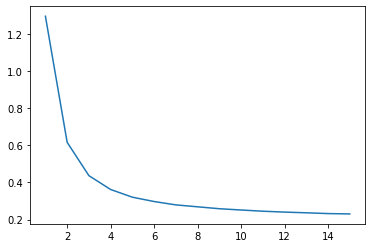

In [23]:
x = [i for i in range(1, hyper.epochs+1)]
y = loss_list
plt.plot(x,y)
plt.show()

In [19]:
def getPredictedFullMatrix(user_embedding, item_embedding, global_mean, user_bias, item_bias):

    num_users = user_embedding.shape[0]
    num_items = item_embedding.shape[0]

    matrix_multiplied_with_bias = np.ones(shape=(num_users, num_items))

    if global_mean is None:
        return user_embedding @ item_embedding.T
    else:
        values = [
            user_embedding @ item_embedding.T,
            matrix_multiplied_with_bias * item_bias,
            np.array([user_bias]).T * matrix_multiplied_with_bias,
            matrix_multiplied_with_bias * global_mean
        ]
        return sum(values)

In [21]:
user_embedding = model.user_embedding.weight.data.detach().cpu().numpy()
item_embedding = model.item_embedding.weight.data.detach().cpu().numpy()
user_biase_embedding = np.squeeze(model.user_bias_embedding.weight.data.detach().cpu().numpy())
item_biase_embedding = np.squeeze(model.item_bias_embedding.weight.data.detach().cpu().numpy())

predict = pd.DataFrame(
    getPredictedFullMatrix(user_embedding, item_embedding, global_mean, user_biase_embedding, item_biase_embedding),
    columns = data.set_movies,
    index = data.set_users
)

predict

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,4.541255,3.268673,3.733323,2.758586,3.941763,4.223502,2.335995,3.593154,3.332051,3.277963,...,4.656973,4.825168,4.955891,5.066469,4.850731,4.785079,5.007418,5.105509,4.825781,4.610891
1,4.640587,4.647205,3.879587,3.638487,4.994726,3.310178,4.169986,4.488691,4.580897,3.556931,...,4.909061,4.613625,4.466398,4.677858,5.426601,4.431877,5.140741,5.152614,5.094354,4.512695
2,4.476894,4.305407,1.771808,3.134586,2.764103,3.405545,4.854968,2.203632,1.950592,3.626805,...,4.161703,3.654097,3.733479,3.904288,3.920938,3.688823,3.796728,4.058354,4.193303,3.695082
3,4.623701,3.505435,2.072833,1.739616,2.410070,3.416078,1.258137,2.986890,2.262819,1.647753,...,4.232395,3.802185,4.615644,5.218127,4.896604,3.978344,4.655009,4.403668,4.531268,4.331128
4,4.203315,3.992628,2.378826,2.851542,5.069207,3.517500,3.849735,2.489796,3.376115,2.657606,...,4.083202,5.040140,4.707536,3.611289,3.031184,4.671480,4.417003,4.936543,4.457183,4.147113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,3.961263,3.034577,2.623880,2.927360,3.026858,4.224631,3.349872,2.653618,2.371942,2.865330,...,4.560386,4.574605,4.787482,4.613914,4.615569,4.539136,4.906668,4.296246,4.560696,4.663172
606,4.347180,2.891072,3.779262,4.564283,3.618605,4.584004,2.677955,1.230883,3.250719,2.426607,...,3.911911,5.113673,3.966566,3.993947,3.538245,4.903988,4.060249,4.903824,3.978189,3.938796
607,3.381187,2.863467,1.338654,3.024237,1.889636,4.286381,3.259626,3.495695,3.359475,3.564735,...,5.073003,4.624624,4.566243,4.865709,4.459692,5.060599,4.232721,4.516377,4.637625,4.604384
608,3.521215,3.749140,1.901281,2.743341,3.294143,3.778263,3.153403,2.850193,3.339333,3.582821,...,3.793907,4.730321,4.113061,4.203710,4.093840,4.143713,4.333779,4.218453,3.913007,4.369889
